In [1]:
import numpy as np 
import torch 
from tqdm import tqdm 
import pickle 
import pandas as pd
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
import requests 
import time 

import datasets
from datasets import load_dataset
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModelForCausalLM
import jailbreakbench as jbb 

import sys
sys.path.append('../') 

from white_box.model_wrapper import ModelWrapper
from white_box.utils import gen_pile_data 
from white_box.dataset import clean_data 
from white_box.chat_model_utils import load_model_and_tokenizer, get_template, MODEL_CONFIGS

from white_box.dataset import PromptDist, ActDataset, create_prompt_dist_from_metadata_path, ProbeDataset
from white_box.probes import LRProbe
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, roc_auc_score

%load_ext autoreload
%autoreload 2

In [2]:
model_name = 'llama2_7b'
data_path = f"/home/ubuntu/rowan/white-box-filtering/data/llama2_7b"
# file_spec = "jb_"
file_spec = "jb_unif_behav_"
# file_spec = "jb_gcg_"

### Train best probe

Labels are based on whether the query is harmful or not. 

In [3]:
layer = 16

# neg_gcg = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0) & ((metadata['jb_name'] == 'GCG') | (metadata['jb_name'] == 'EnsembleGCG'))")
# pos_gcg =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1) & ((metadata['jb_name'] == 'GCG') | (metadata['jb_name'] == 'EnsembleGCG'))")
neg =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['jb_name'] == 'harmless')")
pos = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['jb_name'] == 'DirectRequest')")
print(len(pos.idxs), len(neg.idxs))
dataset = ActDataset([pos], [neg])
dataset.instantiate()
probe_dataset = ProbeDataset(dataset)

37 100


In [4]:
acc, auc, probe = probe_dataset.train_sk_probe(layer, tok_idxs = list(range(5)), test_size = 0.25, C = 1e-3, max_iter = 2000)
print(acc, auc)

0.9771428571428571 1.0


In [3]:
model_name = 'llama2_7b'
data_path = f"/home/ubuntu/rowan/white-box-filtering/data/turkish"
# file_spec = "jb_"
file_spec = "jb_unif_behav_"
# file_spec = "jb_gcg_"

In [4]:
layer = 16

# neg_gcg = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0) & ((metadata['jb_name'] == 'GCG') | (metadata['jb_name'] == 'EnsembleGCG'))")
# pos_gcg =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1) & ((metadata['jb_name'] == 'GCG') | (metadata['jb_name'] == 'EnsembleGCG'))")
neg =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['jb_name'] == 'harmless')")
pos = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['jb_name'] == 'DirectRequest')")
print(len(pos.idxs), len(neg.idxs))
dataset = ActDataset([pos], [neg])
dataset.instantiate()
probe_dataset = ProbeDataset(dataset)

37 100


In [5]:
acc, auc, probe = probe_dataset.train_sk_probe(layer, tok_idxs = list(range(5)), test_size = 0.25, C = 1e-3, max_iter = 2000, 
print(acc, auc)

0.9200000166893005 0.9442735042735042


### Test on Turkish finetuned model

In [6]:
test_data_path = f"/home/ubuntu/rowan/white-box-filtering/data/turkish/"
pos_acts = torch.load(test_data_path + "harmful_behaviors_custom_hidden_states.pt")
neg_acts = torch.load(test_data_path + "harmless_behaviors_custom_hidden_states.pt")

pos_acts.shape, neg_acts.shape

(torch.Size([50, 32, 5, 4096]), torch.Size([50, 32, 5, 4096]))

In [10]:
pos, neg = pos_acts[:, layer].cpu().numpy(), neg_acts[:, layer].cpu()
pos, neg = pos.reshape(-1, pos.shape[-1]), neg.reshape(-1, neg.shape[-1])
pos, neg = torch.tensor(pos), torch.tensor(neg)
X = torch.concat([pos, neg]).cuda()
y = torch.tensor([1] * pos.shape[0] + [0] * neg.shape[0]).detach().cpu()
y_predict = probe.predict(X).detach().cpu()
acc = accuracy_score(y, y_predict)
auc = roc_auc_score(y, y_predict)

print(acc, auc)

0.494 0.494


/tmp/ipykernel_136340/2129924764.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos, neg = torch.tensor(pos), torch.tensor(neg)


(array([65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 35.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

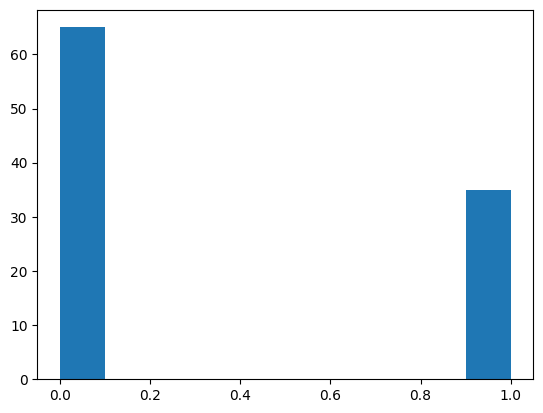

In [31]:
import matplotlib.pyplot as plt
plt.hist(y_predict)

In [32]:
from white_box.probes import LRProbe
pos, neg = pos_acts[:, layer].cpu().numpy(), neg_acts[:, layer].cpu().numpy()
X = np.vstack([pos, neg])
y = np.hstack([np.ones(len(pos)), np.zeros(len(neg))])
lrprobe = LRProbe.from_weights(torch.tensor(probe.coef_), torch.tensor(probe.intercept_), device = "cpu")

y_predict = lrprobe.predict(torch.tensor(X))

(array([28.,  2.,  0.,  1.,  0.,  3.,  0.,  2.,  3., 11.]),
 array([0.04709101, 0.14182274, 0.23655446, 0.33128619, 0.42601791,
        0.52074963, 0.61548138, 0.71021307, 0.80494481, 0.8996765 ,
        0.99440825]),
 <BarContainer object of 10 artists>)

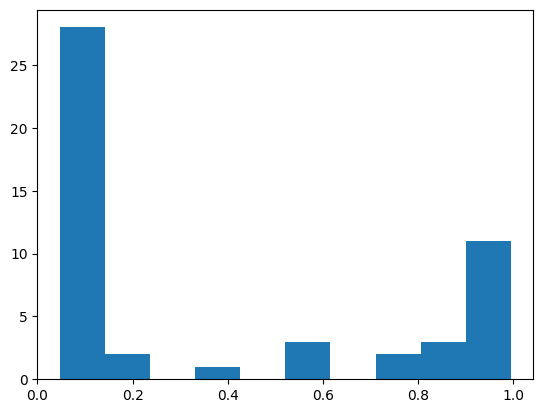

In [33]:
pos = torch.tensor(pos).cpu()
probas = lrprobe.predict_proba(pos)

probas = probas.mean(dim=-1).detach().cpu().numpy()
plt.hist(probas)

(array([28.,  2.,  0.,  1.,  0.,  2.,  1.,  1.,  2., 13.]),
 array([0.04494978, 0.13993242, 0.23491508, 0.32989773, 0.42488036,
        0.51986301, 0.61484563, 0.70982832, 0.80481094, 0.89979362,
        0.99477625]),
 <BarContainer object of 10 artists>)

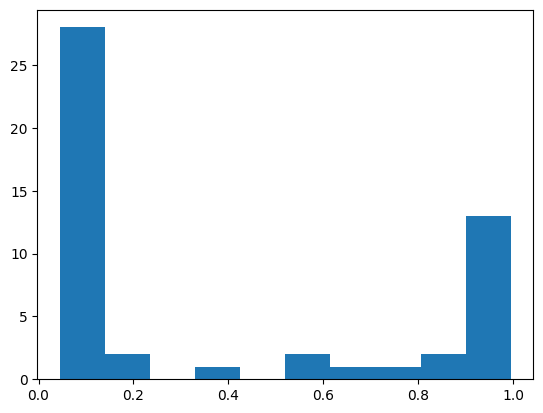

In [34]:
neg = torch.tensor(neg).cpu()
probas = lrprobe.predict_proba(neg)

probas = probas.mean(dim=-1).detach().cpu().numpy()
plt.hist(probas)

In [12]:
pos.device

device(type='cpu')

In [13]:
lrprobe.net[0].bias.device

device(type='cpu')